<div style="text-align: center">
    <img src="public/swps_logo.png" width="1800" alt="SWPS University logotype">
    <h1><strong>A study of Poles' psychedelic and non-psychedelic mystical experiences in relation to fear of death, emotional empathy, and life satisfaction</strong></h1>
</div>
<div style="text-align: center">
    <h3><strong>Part II: Lingustic analysis</strong></h1>
</div>

# **Table of contents**

1. [Brief introduction](#1.-brief-introduction)
2. [Imports](#2.-imports)
    1. [Importing libraries](#2.1.-importing-libraries)
    2. [Loading dataset](#2.2.-loading-dataset)
3. [Data wrangling and cleaning](#3.-data-wrangling-and-cleaning)
    1. [Joining female and male variables into one dataframe](#3.1.-joining-female-and-male-variables-into-one-dataframe)
    2. [Recoding MEQ30 scorings](#3.2.-recoding-MEQ30-scorings**)
    3. [Summing the results and checking for complete mystical experiences](#3.3.-summing-the-results-and-checking-for-complete-mystical-experiences)
    4. [Removing incomplete records from the dataset](#3.4.-removing-incomplete-records-from-the-dataset)
    5. [Filtering records that include description of an experience](#3.5.-filtering-records-that-include-description-of-an-experience)
4. [Translation](#4.-translation)
    1. [Using DeepL REST API](#.4.1.-using-deepl-rest-api)
5. [Data analysis](#5.-data-analysis)
    1. [Word frequency distribution analysis](#5.1.-word-frequency-distribution-analysis)
    2. [Correlation analysis](#5.2.-correlation-analysis)
    3. [Emotional sentiment NLP analysis](#5.3.-emotional-sentiment-nlp-analysis)
    4. [Participants' subjective assessment of the influence](#5.4.-participants'-subjective-assessment-of-the-influence)
6. [Conclusions](#6.-conclusions)
<br>
<br>
<hr>

# **1. Brief introduction**

# **2. Imports**

## **2.1. Importing libraries**

As a first step, we will import all the libraries needed to run the following code cells.

In [2]:
import pandas as pd
import numpy as np
import re
import requests
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from wordcloud import STOPWORDS, WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
from collections import Counter
from scipy.stats import pearsonr, fisher_exact
from PIL import Image, ImageDraw
from transformers import pipeline
from IPython.display import display, HTML

## **2.2. Loading dataset**

Having imported Pandas library, we can now import our Excel dataset and assign it to a variable.

In [3]:
dataset_path = "public/dataset.xlsx"
df = pd.read_excel(dataset_path)

pd.set_option("display.max_columns", None)
df.head()

,start_date,end_date,progress_in_percent,duration_in_seconds,finished,recorded_date,age,sex,survey_version,worldview,education,meditation_M,meditation_minutes_M,compound_never_M,compound_LSD_M,compound_psylocybin_M,compound_ayahuasca_M,compound_DMT_M,compound_5MeODMT_M,compound_mescaline_M,compound_ibogaine_M,compound_salvia_M,compound_other_M,compound_text_M,use_amount_M,microdose_M,low_dose_M,average_dose_M,high_dose_M,very_high_dose_M,mystical_experience_M,context_psychedelic_M,context_other_psychoactive_M,context_NDE_M,context_meditation_M,context_ritual_M,context_hypnosis_M,context_other_M,context_other_psychoactive_text_M,context_other_text_M,trigger_compound_M,order_M,intensity_M,how_long_ago_M,MEQ30_1_M,MEQ30_2_M,MEQ30_3_M,MEQ30_4_M,MEQ30_5_M,MEQ30_6_M,MEQ30_7_M,MEQ30_8_M,MEQ30_9_M,MEQ30_10_M,MEQ30_11_M,MEQ30_12_M,MEQ30_13_M,MEQ30_14_M,MEQ30_15_M,MEQ30_16_M,MEQ30_17_M,MEQ30_18_M,MEQ30_19_M,MEQ30_20_M,MEQ30_21_M,MEQ30_22_M,MEQ30_23_M,MEQ30_24_M,MEQ30_25_M,MEQ30_26_M,MEQ30_27_M,MEQ30_28_M,MEQ30_29_M,MEQ30_30_M,PES_1_M,PES_2_M,PES_3_M,PES_4_M,PES_5_M,PES_6_M,PES_7_M,PES_8_M,PES_9_M,PES_10_M,PES_11_M,SWLS_1_M,SWLS_2_M,SWLS_3_M,SWLS_4_M,SWLS_5_M,DAP_R_1_M,DAP_R_2_M,DAP_R_3_M,DAP_R_4_M,DAP_R_5_M,DAP_R_6_M,DAP_R_7_M,DAP_R_8_M,influence_empathy_M,influence_satisfaction_M,influence_fear_M,description_text_M,meditation_F,meditation_minutes_F,compound_never_F,compound_LSD_F,compound_psylocybin_F,compound_ayahuasca_F,compound_DMT_F,compound_5MeODMT_F,compound_mescaline_F,compound_ibogaine_F,compound_salvia_F,compound_other_F,compound_text_F,use_amount_F,microdose_F,low_dose_F,average_dose_F,high_dose_F,very_high_dose_F,mystical_experience_F,context_psychedelic_F,context_other_psychoactive_F,context_NDE_F,context_meditation_F,context_ritual_F,context_hypnosis_F,context_other_F,context_other_psychoactive_text_F,context_other_text_F,trigger_compound_F,order_F,intensity_F,how_long_ago_F,MEQ30_1_F,MEQ30_2_F,MEQ30_3_F,MEQ30_4_F,MEQ30_5_F,MEQ30_6_F,MEQ30_7_F,MEQ30_8_F,MEQ30_9_F,MEQ30_10_F,MEQ30_11_F,MEQ30_12_F,MEQ30_13_F,MEQ30_14_F,MEQ30_15_F,MEQ30_16_F,MEQ30_17_F,MEQ30_18_F,MEQ30_19_F,MEQ30_20_F,MEQ30_21_F,MEQ30_22_F,MEQ30_23_F,MEQ30_24_F,MEQ30_25_F,MEQ30_26_F,MEQ30_27_F,MEQ30_28_F,MEQ30_29_F,MEQ30_30_F,PES_1_F,PES_2_F,PES_3_F,PES_4_F,PES_5_F,PES_6_F,PES_7_F,PES_8_F,PES_9_F,PES_10_F,PES_11_F,SWLS_1_F,SWLS_2_F,SWLS_3_F,SWLS_4_F,SWLS_5_F,DAP_R_1_F,DAP_R_2_F,DAP_R_3_F,DAP_R_4_F,DAP_R_5_F,DAP_R_6_F,DAP_R_7_F,DAP_R_8_F,influence_empathy_F,influence_satisfaction_F,influence_fear_F,description_text_F
0,2023-02-17 22:50:49,2023-02-17 23:04:08,100,798,1,2023-02-17 23:04:09,28.0,1.0,1.0,2.0,4.0,1.0,200.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,4.0,6.0,6.0,6.0,6.0,6.0,4.0,5.0,5.0,5.0,6.0,5.0,4.0,6.0,5.0,5.0,5.0,4.0,6.0,5.0,5.0,5.0,6.0,5.0,4.0,4.0,5.0,5.0,5.0,6.0,5.0,4.0,4.0,2.0,5.0,2.0,4.0,3.0,3.0,4.0,4.0,2.0,3.0,4.0,2.0,1.0,3.0,5.0,6.0,7.0,5.0,6.0,7.0,7.0,5.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-02-18 00:24:48,2023-02-18 00:34:16,100,567,1,2023-02-18 00:34:18,30.0,1.0,1.0,4.0,4.0,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,3.0,2.0,5.0,3.0,2.0,2.0,3.0,4.0,2.0,1.0,5.0,4.0,4.0,3.0,4.0,3.0,1.0,2.0,3.0,1.0,4.0,4.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

# **3. Data wrangling and cleaning**

## **3.1. Joining female and male variables into one dataframe**

As we have duplicated variables from female (`_F`) and male (`_M`) versions of the survey, we have to combine them together.

In order to achieve this, we have to first identify all the base variables. Let's then look for all the columns that have names ending with `_M` (or `_F`), and then remove the 2-sign suffix from them.

In [4]:
columns_to_process = [col[:-2] for col in df.columns if col.endswith("_M")]
combined_columns = {}

Now we will iterate through our base variables (`columns_to_process`) and identify male and female columns. Then we will fill all the NaN's with: (**A**) zeros for numeric variables and (**B**) empty strings for text variables. As a final step we will combine `_M` and `_F` variables into one dataframe.

In [5]:
for col in columns_to_process:
    male_col = f"{col}_M"
    female_col = f"{col}_F"
    
    if df[male_col].dtype == "float64" and df[female_col].dtype == "float64":
        male_variables = pd.to_numeric(df[male_col], errors="coerce").fillna(0)
        female_variables = pd.to_numeric(df[female_col], errors="coerce").fillna(0)
        
        combined_columns[col] = male_variables + female_variables
        
    elif df[male_col].dtype == "object" and df[female_col].dtype == "object":
        male_variables = df[male_col].fillna("")
        female_variables = df[female_col].fillna("")
        
        combined_columns[col] = male_variables + female_variables

combined_df = pd.DataFrame(combined_columns)

df = pd.concat([df, combined_df], axis=1)

df.drop(columns=[f"{col}_M" for col in columns_to_process] + [f"{col}_F" for col in columns_to_process], inplace=True)

df.head()

,start_date,end_date,progress_in_percent,duration_in_seconds,finished,recorded_date,age,sex,survey_version,worldview,education,meditation,compound_never,compound_LSD,compound_psylocybin,compound_ayahuasca,compound_DMT,compound_5MeODMT,compound_mescaline,compound_ibogaine,compound_salvia,compound_other,compound_text,use_amount,microdose,low_dose,average_dose,high_dose,very_high_dose,mystical_experience,context_psychedelic,context_other_psychoactive,context_NDE,context_meditation,context_ritual,context_hypnosis,context_other,context_other_psychoactive_text,context_other_text,trigger_compound,order,intensity,how_long_ago,MEQ30_1,MEQ30_2,MEQ30_3,MEQ30_4,MEQ30_5,MEQ30_6,MEQ30_7,MEQ30_8,MEQ30_9,MEQ30_10,MEQ30_11,MEQ30_12,MEQ30_13,MEQ30_14,MEQ30_15,MEQ30_16,MEQ30_17,MEQ30_18,MEQ30_19,MEQ30_20,MEQ30_21,MEQ30_22,MEQ30_23,MEQ30_24,MEQ30_25,MEQ30_26,MEQ30_27,MEQ30_28,MEQ30_29,MEQ30_30,PES_1,PES_2,PES_3,PES_4,PES_5,PES_6,PES_7,PES_8,PES_9,PES_10,PES_11,SWLS_1,SWLS_2,SWLS_3,SWLS_4,SWLS_5,DAP_R_1,DAP_R_2,DAP_R_3,DAP_R_4,DAP_R_5,DAP_R_6,DAP_R_7,DAP_R_8,influence_empathy,influence_satisfaction,influence_fear,description_text
0,2023-02-17 22:50:49,2023-02-17 23:04:08,100,798,1,2023-02-17 23:04:09,28.0,1.0,1.0,2.0,4.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,6.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,,,2.0,0.0,0.0,4.0,6.0,6.0,6.0,6.0,6.0,4.0,5.0,5.0,5.0,6.0,5.0,4.0,6.0,5.0,5.0,5.0,4.0,6.0,5.0,5.0,5.0,6.0,5.0,4.0,4.0,5.0,5.0,5.0,6.0,5.0,4.0,4.0,2.0,5.0,2.0,4.0,3.0,3.0,4.0,4.0,2.0,3.0,4.0,2.0,1.0,3.0,5.0,6.0,7.0,5.0,6.0,7.0,7.0,5.0,2.0,2.0,2.0,
1,2023-02-18 00:24:48,2023-02-18 00:34:16,100,567,1,2023-02-18 00:34:18,30.0,1.0,1.0,4.0,4.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,3.0,2.0,5.0,3.0,2.0,2.0,3.0,4.0,2.0,1.0,5.0,4.0,4.0,3.0,4.0,3.0,1.0,2.0,3.0,1.0,4.0,4.0,2.0,0.0,0.0,0.0,
2,2023-02-18 12:57:58,2023-02-18 13:13:33,100,934,1,2023-02-18 13:13:33,25.0,2.0,2.0,2.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Haszysz,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Ciastko z haszyszem,,0.0,0.0,0.0,52.0,6.0,4.0,6.0,5.0,6.0,4.0,6.0,4.0,6.0,6.0,6.0,3.0,6.0,5.0,5.0,5.0,3.0,4.0,6.0,4.0,5.0,6.0,1.0,3.0,2.0,5.0,1.0,5.0,6.0,1.0,4.0,4.0,3.0,3.0,3.0,3.0,3.0,4.0,4.0,3.0,3.0,3.0,3.0,3.0,2.0,2.0,1.0,2.0,1.0,5.0,2.0,2.0,2.0,1.0,3.0,3.0,4.0,
3,2023-02-18 13:14:33,2023-02-18 13:18:33,100,239,1,2023-02-18 13:18:34,22.0,2.0,2.0,4.0,4.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,3.0,2.0,3.0,2.0,3.0,4.0,3.0,2.0,3.0,4.0,2.0,2.0,3.0,4.0,4.0,4.0,5.0,5.0,4.0,4.0,4.0,0.0,0.0,0.0,
4,2023-02-18 13:19:13,2023-02-18 13:26:12,100,419,1,2023-02-18 13:26:13,28.0,2.0,2.0,4.0,4.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,,,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,2.0,2.0,3.0,3.0,2.0,3.0,4.0,3.0,3.0,4.0,5.0,5.0,6.0,5.0,3.0,2.0,2.0,5.0,2.0,3.0,2.0,2.0,0.0,0.0,0.0,


## **3.2. Recoding MEQ30 scorings**

Now we have to transform the Likert scale of MEQ30 scorings to match the original one (0 to 5).

In [6]:
meq30_columns = [col for col in df.columns if col.startswith("MEQ30")]

replacement_mapping = {
    1: 0, 
    2: 1, 
    3: 2, 
    4: 3, 
    5: 4, 
    6: 5
}

df[meq30_columns] = df[meq30_columns].replace(replacement_mapping)

## **3.3. Summing the results and checking for complete mystical experiences**

With the properly transformed scale, we can proceed to summing up the results for each of the questionnaire's subscales. We will also check for criterion of complete mystical experience, which is obtaining at least 60% of the maximal scoring in each of the four subscales. We will also calculate agregated total score for each participant.

In [7]:
MEQ30_subscales = {
    "Mystical": [4, 5, 6, 9, 14, 15, 16, 18, 20, 21, 23, 24, 25, 26, 28],
    "Positive Mood": [2, 8, 12, 17, 27, 30],
    "Transcendence": [1, 7, 11, 13, 19, 22],
    "Ineffability": [3, 10, 29]
}

for subscale, items in MEQ30_subscales.items():
    df.loc[:, subscale] = df[[f"MEQ30_{item}" for item in items]].sum(axis=1)
    
max_score = {
    "Mystical": len(MEQ30_subscales["Mystical"]) * 5,
    "Positive Mood": len(MEQ30_subscales["Positive Mood"]) * 5,
    "Transcendence": len(MEQ30_subscales["Transcendence"]) * 5,
    "Ineffability": len(MEQ30_subscales["Ineffability"]) * 5
}

df["MEQ_complete"] = (
    (df["Mystical"] / max_score["Mystical"] >= 0.6) &
    (df["Positive Mood"] / max_score["Positive Mood"] >= 0.6) &
    (df["Transcendence"] / max_score["Transcendence"] >= 0.6) &
    (df["Ineffability"] / max_score["Ineffability"] >= 0.6)
).astype(int)

df["MEQ_total_score"] = (
    df["Mystical"] +
    df["Positive Mood"] +
    df["Transcendence"] +
    df["Ineffability"]
)

df.iloc[:10, -6:]

,Mystical,Positive Mood,Transcendence,Ineffability,MEQ_complete,MEQ_total_score
0,60.0,23.0,27.0,15.0,1,125.0
1,0.0,0.0,0.0,0.0,0,0.0
2,50.0,10.0,30.0,15.0,0,105.0
3,0.0,0.0,0.0,0.0,0,0.0
4,0.0,0.0,0.0,0.0,0,0.0
5,15.0,14.0,6.0,3.0,0,38.0
6,62.0,26.0,27.0,13.0,1,128.0
7,0.0,0.0,0.0,0.0,0,0.0
8,0.0,0.0,0.0,0.0,0,0.0
9,0.0,0.0,0.0,0.0,0,0.0


## **3.4. Removing incomplete records from the dataset**

To clean our dataset from incomplete records, we will drop all the rows that have `0` value in the `finished` column.

In [8]:
incomplete_survey = df[df["finished"] == 0]

df.drop(incomplete_survey.index, inplace=True)
df.reset_index(drop=True, inplace= True)

print(f"We have dropped {incomplete_survey.shape[0]} records, and are left with {df.shape[0]} completed surveys.")

We have dropped 403 records, and are left with 724 completed surveys.


## **3.5. Filtering records that include description of an experience**

As in the following sections we are going to analyze descriptions of participants' experiences, it will be convenient to create a new dataframe that consists only of these people who decided to share their experience in the optional text field.

In [9]:
df_desc = df[df["description_text"] != ""]
df_desc.reset_index(drop=True, inplace= True)

print(f"Out of these {df.shape[0]} records, {df_desc.shape[0]} participants decided to share a description of their experience.")

Out of these 724 records, 338 participants decided to share a description of their experience.


# **4. Translation**

The research was conducted on Polish sample, hence all the obtained descriptions are written in Polish language. As most of the popular NLP tools are originally trained on English inputs, we will perform a translation of our descriptions to facilitate firther analysis. For this purpose we will use `DeepL` machine-learning-based translator.

## **4.1. Using DeepL REST API**

*The following code cells had been executed using a private API key, and then were disabled by commenting them out.*

Let's first create a function that constructs a POST request to the `DeepL` API's translation endpoint. This function will send the original text along with the specified target language and the provided API key. After receiving the response from the API, the function will extract the translated text and return it as a string.

In [10]:
# def translate(description, target_lang="EN-US", api_key="API_KEY_PLACEHOLDER"):
#     url = "https://api.deepl.com/v2/translate"
#     params = {
#         "auth_key": api_key,
#         "text": description,
#         "target_lang": target_lang
#     }
#     response = requests.post(url, data=params)
#     result = response.json()
#     return result["translations"][0]["text"]

Now we will extract the Polish descriptions from the `description_text` column. Then, we will create an empty list to store the English translations. For each Polish description, we will attempt to translate it into English using previously created `translate` function. If the translation is successful, the translated text will be appended to the list. If an error occurs during the translation, the error will be logged, and `None` will be appended to the list instead. Finally, we will create a new DataFrame by copying the original one and adding a new column with translated English descriptions.

In [11]:
# polish_descriptions = df_desc["description_text"]

# english_descriptions = []

# for description in polish_descriptions:
#     try:
#         translated_description = translate(description)
#         english_descriptions.append(translated_description)
#     except Exception as e:
#         print(f"Error translating text: {description}, error: {e}")
#         english_descriptions.append(None)

# df_translated = df_desc.copy()
# df_translated["description_text_EN"] = english_descriptions

Once the translation process is executed, and `description_text_EN` column appended, we can export our new dataframe as an Excel file.

In [12]:
# df_translated.to_excel("public/dataset_with_english_descriptions.xlsx", index=False)

Let's now check a sample of the translated texts.

In [13]:
translated_dataset_path = "public/dataset_with_english_descriptions.xlsx"
df_english = pd.read_excel(translated_dataset_path)

pd.set_option("display.max_colwidth", 1000)
df_english[["description_text", "description_text_EN", "MEQ_total_score", "MEQ_complete"]].head()

,description_text,description_text_EN,MEQ_total_score,MEQ_complete
0,"Po ponad 72 godzinach bez snu w trakcie których zażywałem duże ilości mdma, psylocybiny oraz thc - gdy sen w końcu nadszedł, byłem podczas tego praktycznie sto procent świadomy - to ja decydowałem co będzie się działo dalej, podejmując decyzję wynikające z wewnętrznego dialogu. W pewnym momencie poczułem niesamowita błogość i ciepło i zobaczyłem siebie leżącego na łóżku obok mojej partnerki - widziałem siebie, z zaciekawieniem się sobie przyglądałem. To trwało jakieś 5 może 10 minut, podczas których płakałem i cieszyłem się jednocześnie. Zmieniło to moje życie w takim sensie, że zastanawiałem się a co jeśli będąc w takim stanie spotkam kogoś kto też w nim jest? Co się stanie? Czy będziemy mogli się porozumieć?","After more than 72 hours without sleep during which I took large amounts of mdma, psilocybin and thc - when sleep finally came, I was practically one hundred percent conscious during it - I was the one who decided what was going to happen next, making decisions resulting from the internal dialogue. At one point, I felt incredible bliss and warmth and saw myself lying on the bed next to my partner - I could see myself, curiously looking at myself. This went on for about 5 maybe 10 minutes, during which I cried and rejoiced at the same time. It changed my life in the sense that I wondered what if, being in this state, I meet someone who is also in it? What will happen? Will we be able to communicate?",119,1
1,Wyleczyło mnie z dolegliwości które lekarze bezskutecznie leczyli od 15 lat,It cured me of ailments that doctors had been treating for 15 years without success,130,1
2,"Doświadczenie miało miejsce 7 lat temu. Podczas jazdy małym busem bez świateł w środku słuchałam jakiegoś powolnego utworu. Zamknęłam oczy i położyłam głowę na oparciu. Podróż mogła trwać max 20 minut - dla mnie trwała pare godzin. Czułam jakbym ja była w muzyce, nie potrafie tego opisać. Wiedziałam, ze po otwarciu oczu mogłabym wcale już nie być w busie, było błogo, czułam się bezpiecznie, że unoszę się w powietrzu, a nie jestem w swoim ciele, byłam gdzieś daleko. Do teraz nie wiem jak to opisać, ani co to było. To doświadczenie na pewno zostanie ze mną do końca życia jako niesamowite i niewyjaśnione uniesienie.","The experience took place 7 years ago. While driving a small bus with no lights inside, I was listening to some slow song. I closed my eyes and laid my head on the backrest. The trip may have lasted 20 minutes max - for me it lasted a couple of hours. I felt like I was in the music, I can't describe it. I knew that after opening my eyes I might not be in the bus at all anymore, it was blissful, I felt safe, that I was floating in the air, not in my body, I was somewhere far away. To this day I don't know how to describe it or what it was. This experience will definitely stay with me for the rest of my life as an amazing and unexplained rapture.",92,0
3,"Wrazenie podrzymywania mnie jako osoby,które bylo we mnie ale nie ze mnie",Along with holding me up as a person that was in me but not of me,77,0
4,"jak to jest, że coś tak materialnego jak umysł może dać początek czemuś tak niematerialnemu jak doświadczenie?",How is it that something as material as the mind can give rise to something as immaterial as experience?,64,0


Looks good! We can now proceed to the analysis!

# **5. Data analysis**

We have our dataset clean and wrangled, our texts translated, so now we are ready for the analysis. In this section we are going to perform:

- Word frequency distribution analysis
- Words vs MEQ30 scores correlation analysis
- Emotional sentiment analysis
- Subjective impact assesment analysis

## **5.1. Word frequency distribution analysis**

Let's begin from counting the frequencies of words' use. For this we will need all of our descriptions concatenated as a single string.

In [14]:
concatenated_descriptions = " ".join(df_english["description_text_EN"])

Now we will use  `word_tokenize` function from `nltk` to obtain tokens out of the used words. The `STOPWORDS` set from `wordcloud` library will allow us to filter out all the common stopword tokens, i.e. "not", "who", "too", "so" etc.

In [15]:
tokens = word_tokenize(concatenated_descriptions.lower())
stopwords = set(STOPWORDS).union({"ve"})

filtered_tokens = [
    word for word in tokens if 
    word.isalpha() and word not in stopwords
]

Now as we have our tokens filtered, we can count the occurences of the most frequent tokens.

In [16]:
word_frequencies = Counter(filtered_tokens)
top_25_words = word_frequencies.most_common(25)

top_25_words

[('experience', 244),
 ('life', 168),
 ('felt', 135),
 ('time', 117),
 ('body', 80),
 ('everything', 75),
 ('one', 74),
 ('something', 66),
 ('feeling', 64),
 ('experienced', 64),
 ('experiences', 61),
 ('feel', 58),
 ('love', 57),
 ('world', 56),
 ('sense', 53),
 ('know', 50),
 ('state', 48),
 ('death', 48),
 ('saw', 43),
 ('first', 42),
 ('trip', 41),
 ('reality', 41),
 ('people', 40),
 ('able', 38),
 ('many', 38)]

As we can see, the output is a list of tuples containing tokens (in this case we can treat tokens equally to words), and their frequencies. Let's visualize the results as a bar plot.

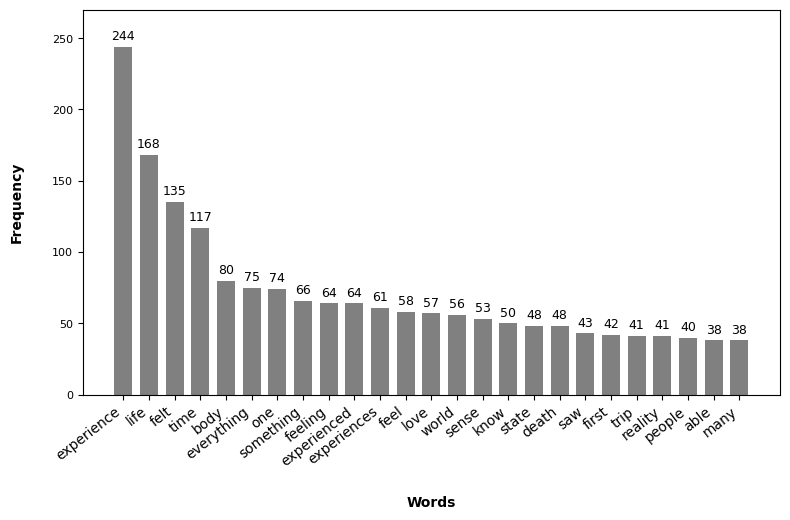

In [17]:
words, frequencies = zip(*top_25_words)

plt.figure(figsize=(9, 5))
plt.xlabel("Words", fontweight="bold", fontsize=10, labelpad=20)
plt.ylabel("Frequency", fontweight="bold", fontsize=10, labelpad=20)
plt.xticks(rotation=38, ha="right", fontsize=10)
plt.yticks(fontsize=8)
plt.ylim(0, 270)

bars = plt.bar(words, frequencies, color="grey", width=0.7)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval + 5, int(yval), ha="center", fontsize=9)

figure1_html = """
<p style="font-size: 14px">
    <strong>Figure 1.</strong> Frequency distribution of the 25 most common words used in the analyzed descriptions (<i>N</i> = 338) excluding predefined stopwords.
</p>
"""
display(HTML(figure1_html))

plt.show()

We can observe that the word `experience` (along with its variations: `experienced`, `experiences`) clearly stands out from the rest, indicating its frequent usage, which is intuitive given the context. In addition, several words carry an existential tone, such as `life`, `death`, `time`, `reality`, `people`, and `world`. A significant portion of the words is also related to feelings, emotions, or sensory experiences, including `felt`, `feeling`, `feel`, `love`, `sense`, `body`, `know`, and `saw`. Another category comprises words that suggest quantity or range, such as `everything`, `something`, `one`, `many`, and `first`.

Considering this, we can state that the descriptions of experiences revolve around existential themes, with a high emphasis on emotions and feelings or sensory sensations. They also frequently include words that point to an experience of plurality or oneness.

## **5.2. Correlation analysis**

Now we will test whether there are any words that are positively or negatively correlated with the intensity of an experience, as measured by the `MEQ30_total_scoring`.

**Steps:**

1. **Filter the tokens:**  
   We will use a regular expression to filter out tokens that start with numeric symbols or are plain digits themselves. This will help in focusing on meaningful words rather than numeric tokens.

2. **Convert the text to a feature matrix:**  
   We will use the `CountVectorizer` function from `scikit-learn` to convert the collection of text documents into a matrix of token counts. This function will:
   - Tokenize the text (split it into individual words).
   - Build a vocabulary of all unique words in the text data.
   - Create a matrix where each row corresponds to a document, and each column represents a word from the vocabulary. The matrix entries will denote the frequency of each word in each document.

3. **Prepare the data for analysis:**  
   The resulting output will be a DataFrame where each column corresponds to a unique word token appearing in the descriptions. The value in each column will represent the frequency of use for that word by each participant. We will also concatenate the `MEQ_total_score` column to this DataFrame to enable correlation analysis.

This approach will allow us to investigate the relationship between specific words and the intensity of the experience reported, providing insights into how different terms are associated with varying levels of experience intensity.


In [18]:
numeric_starting_tokens = set()
for text in df_english["description_text_EN"]:
    tokens = re.findall(r"\d\w*", text)
    numeric_starting_tokens.update(tokens)

tokens_to_remove = list(numeric_starting_tokens)

stopwords_list = list(stopwords)
stopwords_list.extend(tokens_to_remove)
    
vectorizer = CountVectorizer(stop_words=stopwords_list)
X = vectorizer.fit_transform(df_english["description_text_EN"])

word_features = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

df_combined = pd.concat([df_english[["MEQ_total_score"]], word_features], axis=1)

df_combined.head(10)

c:\Users\Huawei\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  warnings.warn(


MEQ_total_score  abandoned  abilities  ability  able  absence  absolute  \
0              119          0          0        0     1        0         0   
1              130          0          0        0     0        0         0   
2               92          0          0        0     0        0         0   
3               77          0          0        0     0        0         0   
4               64          0          0        0     0        0         0   
5               26          0          0        0     0        0         0   
6               94          0          0        0     1        0         0   
7              116          0          0        0     0        0         0   
8               74          0          0        0     0        0         0   
9              114          0          0        0     0        0         0   

   absolutely  absorbing  abstract  abundance  abuse  abusing  abusive  abyss  \
0           0          0         0          0      0        0        0      0   
1           0          0         0          0      0        0        0      0   
2           0          0         0          0      0        0        0      0   
3           0          0         0          0      0        0        0      0   
4           0          0         0          0      0        0        0      0   
5           0          0         0          0      0        0        0      0   
6           0          0         0          0      0        0        0      0   
7           0          0         0          0      0        0        0      0   
8           0          0         0          0      0        0        0      0   
9           0          0         0          0      0        0        0      0   

   accent  accept  acceptance  accepted  accepting  access  accident  \
0       0       0           0         0          0       0         0   
1       0       0           0         0          0       0         0   
2       0       0           0         0          0       0         0   
3       0       0           0         0          0       0         0   
4       0       0           0         0          0       0         0   
5       0       0           0         0          0       0         0   
6       0       0           0         0          0       0         0   
7       0       0           0         0          0       0         0   
8       0       0           0         0          0       0         0   
9       0       0           0         0          0       0         0   

   accompanied  accompany  accompanying  accomplishment  acct  acha  achieve  \
0            0          0             0               0     0     0        0   
1            0          0             0               0     0     0        0   
2            0          0             0               0     0     0        0   
3            0          0             0               0     0     0        0   
4            0          0             0               0     0     0        0   
5            0          0             0               0     0     0        0   
6            0          0             0               0     0     0        0   
7            0          0             0               0     0     0        0   
8            0          0             0               0     0     0        0   
9            0          0             0               0     0     0        0   

   achieved  achieving  acid  acquainted  across  act  action  actions  \
0         0          0     0           0       0    0       0        0   
1         0          0     0           0       0    0       0        0   
2         0          0     0           0       0    0       0        0   
3         0          0     0           0       0    0       0        0   
4         0          0     0           0       0    0       0        0   
5         0          0     1           0       0    0       0        0   
6         0          0     0           0       0    0       

After doing the above preparation, we are ready to perform the correlation analysis in order to determine which word tokens in the `word_features` dataframe are linked with the `MEQ_total_score`. We will calculate the Pearson correlation coefficient (*r*) and *p*-value for each word token using `pearsonr` function from `SciPy` library. Tokens with statistically significant *p*-values (less than 0.05) will be included in the results. The results will then be categorized into those with positive and negative correlations.


In [19]:
correlation_results = []

for col in word_features.columns:
    feature_data = df_combined[col]
    corr, p_value = pearsonr(df_combined["MEQ_total_score"].loc[feature_data.index], feature_data)
    
    if p_value < 0.05:
         correlation_results.append((col, f"{corr:.2f}", f"{p_value:.3f}"))

results_df = pd.DataFrame(correlation_results, columns=["Token", "Pearson's r", "p-value"])
results_df["Pearson's r"] = results_df["Pearson's r"].astype(float)

positive_r = results_df[results_df.apply(lambda x: x ["Pearson's r"] > 0, axis=1)]
negative_r = results_df[results_df.apply(lambda x: x ["Pearson's r"] < 0, axis=1)]

sorted_positive_r = positive_r.sort_values(by="Pearson's r", ascending=False)
sorted_negative_r = negative_r.sort_values(by="Pearson's r", ascending=True)

print(f"We've got {sorted_positive_r.shape[0]} words positively, and {sorted_negative_r.shape[0]} words negatively correlated with the MEQ30 scores.")

We've got 29 words positively, and 166 words negatively correlated with the MEQ30 scores.


So let's see the top 10 words positively correlated with the intensity of an experience.

In [20]:
sorted_positive_r.head(10)

,Token,Pearson's r,p-value
190,world,0.15,0.007
82,infinite,0.15,0.007
4,always,0.14,0.012
41,died,0.14,0.008
49,energy,0.14,0.012
76,heaven,0.13,0.018
161,stage,0.13,0.020
94,let,0.13,0.016
80,huge,0.13,0.018
192,years,0.13,0.019


And here we will display top 10 negative correlations.

In [21]:
sorted_negative_r.head(10)

,Token,Pearson's r,p-value
60,frightened,-0.21,0.000
53,example,-0.20,0.000
25,communion,-0.20,0.000
55,facts,-0.19,0.000
20,call,-0.19,0.001
12,bad,-0.18,0.001
139,recommend,-0.17,0.002
167,tachycardia,-0.17,0.002
127,pleasant,-0.17,0.001
181,unrealness,-0.17,0.002


### **5.2.1. Visualizing the correlations as word clouds**

Let's visualize the correlation analysis results as word clouds.

For this purpose we will create an ellipse mask image that we will then use to form a shape of the clouds.

In [22]:
width, height = 800, 500
ellipse_width = width * 0.85
ellipse_height = height * 0.9

mask = Image.new("L", (width, height), 255)
draw = ImageDraw.Draw(mask)

draw.ellipse(
    [(width // 2 - ellipse_width // 2, height // 2 - ellipse_height // 2),
     (width // 2 + ellipse_width // 2, height // 2 + ellipse_height // 2)],
    fill=0
)

mask.save("public/ellipse_mask.png")

When we have our mask ready, we can create the first word cloud showing the 29 positively correlated words. We will implement our custom color theme along with externally imported font for more aesthetic look.

C:\Users\Huawei\AppData\Local\Temp\ipykernel_17392\3277775162.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  blues = plt.cm.get_cmap("Blues")


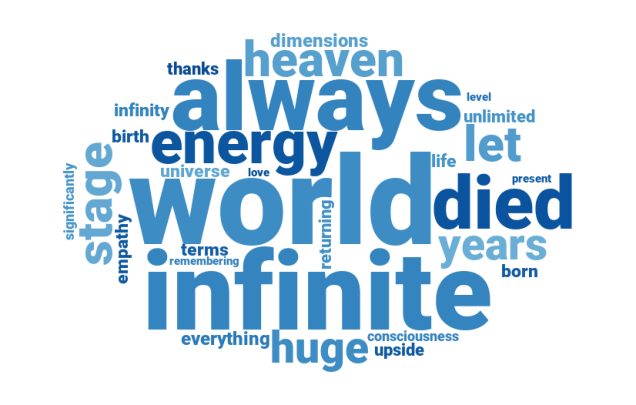

In [23]:
word_frequencies = dict(zip(sorted_positive_r["Token"], sorted_positive_r["Pearson's r"]))

blues = plt.cm.get_cmap("Blues")
start = 0.5
end = 0.9
edited_blues = LinearSegmentedColormap.from_list("new_blues", blues(np.linspace(start, end, 256)))

roboto_font = "public/fonts/Roboto/Roboto-Black.ttf"
mask_image = np.array(Image.open("public/ellipse_mask.png"))

wordcloud = WordCloud(
    width=800, 
    height=600,
    background_color="white",
    colormap=edited_blues,
    font_path=roboto_font,
    mask=mask_image
).generate_from_frequencies(word_frequencies)

plt.figure(figsize=(8, 5))
plt.imshow(wordcloud)
plt.axis("off")

figure2_html = """
<p style="font-size: 14px">
    <strong>Figure 2.</strong> Word cloud illustrating 29 words that are positively correlated with MEQ30 scores.
    Larger words represent stronger correlations, with correlation coefficient (<i>r</i>) ranging from 0.11 to 0.15 
    and <i>p</i>-values less than 0.05 for each word. The hue of the words was randomly assigned to enhance readability.
</p>
"""
display(HTML(figure2_html))

plt.show()

As we can observe, the words exhibit a range of themes:

  - **Spiritual and cosmic concepts:** Words such as `universe`, `everything`, `world`, `dimensions`, `infinity`, `heaven`, `consciousness` and `energy` are linked with more intense mystical experiences. These terms suggest that higher experience intensity may be related to feelings or thoughts about the vastness of the universe or spiritual concepts.

  - **Emotional and psychological states:** Words like `love`, `empathy` or `remembering` indicate a focus on emotional and psychological dimensions.

  - **Life and existence:** Terms like `life`, `died`, `birth`, `born` suggest a connection between the intensity of experiences and reflections on life and existence.

  - **Temporal and quantitative references:** Words such as `years`, `always`, `present`, `level`, `stage`, `huge` or `unlimited` may reflect different aspects of time, scale, or current state, which also show a correlation with the intensity of experiences.
  
In summary, these results highlight that certain words related to existential, spiritual, emotional, and temporal themes are positively associated with higher experience intensity scores.


C:\Users\Huawei\AppData\Local\Temp\ipykernel_17392\1205509296.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  blues = plt.cm.get_cmap("Blues")


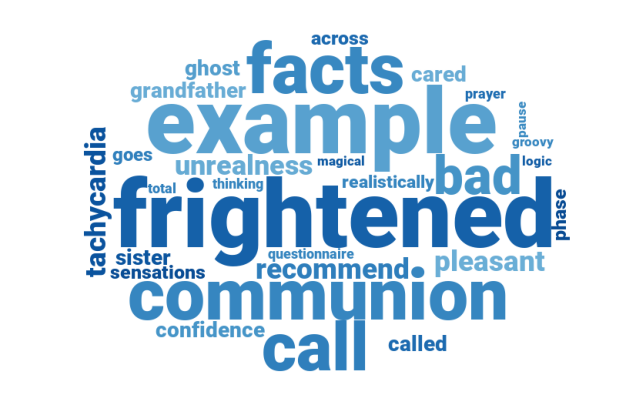

In [24]:
absolute_negative_R_values = sorted_negative_r["Pearson's r"].abs()

word_frequencies = dict(zip(sorted_negative_r["Token"], absolute_negative_R_values))
limited_word_frequencies = dict(list(word_frequencies.items())[:29])

blues = plt.cm.get_cmap("Blues")
start = 0.5
end = 0.9
edited_blues = LinearSegmentedColormap.from_list("new_blues", blues(np.linspace(start, end, 256)))

wordcloud = WordCloud(
    width=800, 
    height=400,
    background_color="white",
    colormap=edited_blues,
    font_path=roboto_font,
    mask=mask_image
).generate_from_frequencies(limited_word_frequencies)

plt.figure(figsize=(8, 5))
plt.imshow(wordcloud)
plt.axis("off")

figure3_html = """
<p style="font-size: 14px">
    <strong>Figure 3.</strong> Word cloud illustrating top 29 words that are negatively correlated with MEQ30 scores.
    Larger words represent stronger correlations, with correlation coefficient (<i>r</i>) ranging from -0.14 to -0.21 
    and <i>p</i>-values less than 0.05 for each word. The hue of the words was randomly assigned to enhance readability.
</p>
"""
display(HTML(figure3_html))

plt.show()

The themes that can be extracted from the negatively correlated words are:

  - **Intense and/or negative emotional and psychological states:** Words such as `frightened`, `bad`, `unrealness` are associated with more negative or unsettling experiences. These terms suggest that negative emotional states or discomfort is linked to lower scores on mystical experiences scale.

  - **Conceptual and factual terms:** Words like `example`, `facts`, `realistically` and `logic` appear to be associated with a more analytical or less emotionally charged context, indicating that higher intensity experiences may be less related to factual or conceptual references.

  - **Personal and relational terms:** Words such as `grandfather`, `sister`, `cared`, and `called` relate to personal relationships or specific individuals, which may imply that experiences involving these terms tend to be less intense.

  - **Religious terms:** Words like `communion`, `ghost`, `prayer` reference to a religious nomenclature, which also show a negative correlation with the intensity of mystical experiences.

In summary, these results highlight that certain words related to negative emotional states, factual or conceptual terms, personal relationships, and religious nomenclature are negatively associated with higher experience intensity scores.


## **5.3. Emotional sentiment NLP analysis**

In this section, we perform an emotional sentiment analysis using the `EmoRoBERTa` pre-trained NLP model, fine-tuned for emotion detection in text. The analysis is conducted separately for two groups: those who met the criteria for a complete mystical experience and those who did not. This separation allows us to explore potential differences in the emotional undertone present in the descriptions provided by both groups.

### **5.3.1. Complete mystical experiences**

So let's start by analyzing the descriptions from participants who met the criteria for complete mystical experiences. First, we will filter the dataset to include only the records of participants who had a complete mystical experience. Then, we will extract the English text descriptions and pass them through the EmoRoBERTa sentiment analysis pipeline in batches for more efficient processing. Finally, we will store the sentiment results and print the total number of chunks analyzed.

In [25]:
model_name = "arpanghoshal/EmoRoBERTa"
sentiment_pipeline = pipeline("sentiment-analysis", model=model_name)

filtered_df_complete = df_english[df_english["MEQ_complete"] == 1]
descriptions_complete = filtered_df_complete["description_text_EN"].tolist()
sentiment_results_complete = []

batch_size = 32

for i in range(0, len(descriptions_complete), batch_size):
    batch = descriptions_complete[i:i + batch_size]
    results = sentiment_pipeline(batch)
    sentiment_results_complete.extend(results)

total_results = len(sentiment_results_complete)
print(f"\nNumber of chunks analyzed: {total_results}\n")

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at arpanghoshal/EmoRoBERTa.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.



Number of chunks analyzed: 152



We have just analyzed 152 descriptions. Let's see what the results are.

To interpret the sentiment analysis, we will first identify the unique emotion labels generated by the EmoRoBERTa model. We will then aggregate the scores for each label to understand the overall emotional distribution in the descriptions. Next, we will calculate the percentage representation of each emotion by comparing its aggregated score to the total score across all labels. Finally, we will print out these results, giving us a clear picture of the emotional sentiment present in the complete mystical experience descriptions.

In [26]:
unique_labels = set(result["label"] for result in sentiment_results_complete)
label_counts = {label: 0 for label in unique_labels}

for result in sentiment_results_complete:
    label_counts[result["label"]] += result["score"]

emotion_data_complete = [(label, label_counts[label]) for label in unique_labels]
total_score_complete = sum(label_counts.values())
percentage_data_complete = [(label, (score / total_score_complete) * 100) for label, score in emotion_data_complete]

print("Aggregated emotion analysis results:\n")
for emotion, score in percentage_data_complete:
    print(f"{emotion.capitalize()}: {score:.2f}%")

Aggregated emotion analysis results:

Surprise: 3.15%
Embarrassment: 0.53%
Nervousness: 0.40%
Optimism: 0.98%
Approval: 10.13%
Sadness: 2.93%
Joy: 9.48%
Desire: 0.55%
Fear: 4.34%
Love: 6.12%
Caring: 1.49%
Gratitude: 5.57%
Realization: 23.90%
Relief: 1.36%
Admiration: 15.49%
Excitement: 1.17%
Confusion: 1.11%
Amusement: 0.32%
Neutral: 9.85%
Grief: 0.43%
Disappointment: 0.70%


### **5.3.2. Non-complete mystical experiences**

Now we are going to repeat the same methods for the other group.

In [27]:
model_name = "arpanghoshal/EmoRoBERTa"
sentiment_pipeline = pipeline("sentiment-analysis", model=model_name)

filtered_df_non_complete = df_english[df_english["MEQ_complete"] == 0]
descriptions_non_complete = filtered_df_non_complete["description_text_EN"].tolist()
sentiment_results_non_complete = []

batch_size = 32

for i in range(0, len(descriptions_non_complete), batch_size):
    batch = descriptions_non_complete[i:i + batch_size]
    results = sentiment_pipeline(batch)
    sentiment_results_non_complete.extend(results)

total_results = len(sentiment_results_non_complete)
print(f"\nNumber of chunks analyzed: {total_results}\n")

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at arpanghoshal/EmoRoBERTa.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.



Number of chunks analyzed: 186



In [28]:
unique_labels = set(result["label"] for result in sentiment_results_non_complete)
label_counts = {label: 0 for label in unique_labels}

for result in sentiment_results_non_complete:
    label_counts[result["label"]] += result["score"]

emotion_data_non_complete = [(label, label_counts[label]) for label in unique_labels]
total_score_non_complete = sum(label_counts.values())
percentage_data_non_complete = [(label, (score / total_score_non_complete) * 100) for label, score in emotion_data_non_complete]

print("Aggregated emotion analysis results:\n")
for emotion, score in percentage_data_non_complete:
    print(f"{emotion.capitalize()}: {score:.2f}%")

Aggregated emotion analysis results:

Surprise: 6.90%
Nervousness: 1.05%
Optimism: 1.33%
Approval: 7.24%
Sadness: 3.06%
Joy: 9.52%
Fear: 13.31%
Love: 4.46%
Caring: 0.88%
Gratitude: 4.29%
Realization: 31.49%
Relief: 0.76%
Admiration: 3.98%
Excitement: 0.34%
Curiosity: 1.06%
Amusement: 0.43%
Neutral: 8.25%
Grief: 0.52%
Disappointment: 1.14%


### **5.3.3. Bar plots for both groups**

To better understand and compare the emotional responses between the two groups (complete and non-complete mystical experience), we will visualize the results using bar plots. Specifically, we will create horizontal bar plots that display the top 10 most frequently occurring emotions, ranked by their summed results across both groups. Each emotion will have separate bars representing the two groups. We will also calculate, if there are any statistically significant differencess between them.

So, first of all, we will create variables to access the following:

 - `emotion_names`: Extracted from both groups and capitalized.
 - `emotion_scores`: The raw scores for each emotion in both groups.
 - `percentage_labels`: The percentage representation of each emotion relative to the total scores in both groups.

In [29]:
emotion_names_complete = [emotion[0].capitalize() for emotion in percentage_data_complete]
emotion_names_non_complete = [emotion[0].capitalize() for emotion in percentage_data_non_complete]

emotion_scores_complete = [emotion[1] for emotion in emotion_data_complete]
emotion_scores_non_complete = [emotion[1] for emotion in emotion_data_non_complete]

percentage_labels_complete = [emotion[1] for emotion in percentage_data_complete]
percentage_labels_non_complete = [emotion[1] for emotion in percentage_data_non_complete]


Next, we will create a set of aggregated emotions from both groups to ensure we account for all emotions present.

In [30]:
all_emotions = sorted(set(emotion_names_complete + emotion_names_non_complete))

Then we will build the dictionaries to map each emotion to its percentage and score for both groups, and set `0` for each emotion that is not present in a given group.

In [31]:
complete_percentages_dict = dict(zip(emotion_names_complete, percentage_labels_complete))
non_complete_percentages_dict = dict(zip(emotion_names_non_complete, percentage_labels_non_complete))

sorted_complete_percentages = [complete_percentages_dict.get(emotion, 0) for emotion in all_emotions]
sorted_non_complete_percentages = [non_complete_percentages_dict.get(emotion, 0) for emotion in all_emotions]

complete_scores_dict = dict(zip(emotion_names_complete, emotion_scores_complete))
for emotion in all_emotions:
    if emotion not in complete_scores_dict:
        complete_scores_dict[emotion] = 0
        
non_complete_scores_dict = dict(zip(emotion_names_non_complete, emotion_scores_non_complete))
for emotion in all_emotions:
    if emotion not in non_complete_scores_dict:
        non_complete_scores_dict[emotion] = 0


Now we can finally perform the **Fisher's Exact Test** (imported from `SciPy` library)  to determine if there are any significant differences in the prevalence of each emotion between the two groups: those with a complete mystical experience and those without.

For each emotion in our `all_emotions`, we will construct a contingency table of observed data as follows:

| Complete group           | Non-complete group       |
|--------------------------|--------------------------|
| Emotion X score          | Emotion X score          |
| All other emotion scores | All other emotion scores |

Using this contingency table, we can calculate the **odds ratio**, which measures the ratio of the odds of observing the emotion in the complete group relative to the odds in the non-complete group. The odds ratio provides insight into the strength of the association between the emotion and the group status.

Additionally, we will compute the corresponding ***p*-value** to test the null hypothesis that there is no association between the emotion and the group status. The *p*-value indicates whether the observed differences are statistically significant.

In [50]:
fisher_results = []

for emotion in all_emotions:
    observed = [
        [
            complete_scores_dict[emotion], 
            non_complete_scores_dict[emotion]
        ],
        [
            total_score_complete - complete_scores_dict[emotion], 
            total_score_non_complete - non_complete_scores_dict[emotion]
        ]
    ]
    
    oddsratio, p_value = fisher_exact(observed)
    
    fisher_results.append({
        "Emotion": emotion,
        "Odds ratio": f"{oddsratio:.2f}",
        "p-value": f"{p_value:.4f}"
    })

fisher_results_df = pd.DataFrame(fisher_results)

fisher_results_df

,Emotion,Odds ratio,p-value
0,Admiration,4.98,0.0009
1,Amusement,nan,1.0000
2,Approval,1.50,0.3807
3,Caring,1.22,1.0000
4,Confusion,inf,0.4515
5,Curiosity,0.00,1.0000
6,Desire,nan,1.0000
7,Disappointment,0.00,1.0000
8,Embarrassment,nan,1.0000
9,Excitement,inf,0.4511


As we can see, the scores of **Admiration** (*p* < 0.001) and **Fear** (*p* < 0.05) had significant differences between the groups.

Now let's visualize the results of top 10 most frequently occuring emotions highliting in bold the pairs of percentage scores that differ significantly.

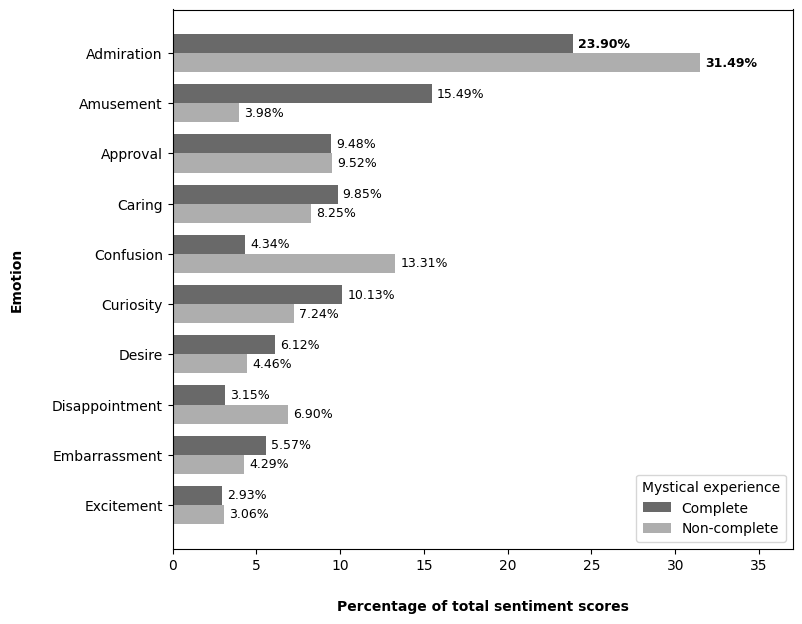

In [63]:
p_value_dict = {row["Emotion"]: float(row["p-value"]) for _, row in fisher_results_df.iterrows()}

sum_percentages = {emotion: complete + non_complete 
                   for emotion, complete, non_complete 
                   in zip(all_emotions, sorted_complete_percentages, sorted_non_complete_percentages)}

sorted_emotions = sorted(sum_percentages.items(), key=lambda x: x[1], reverse=True)
top_n = 10
top_emotions = sorted_emotions[:top_n]
top_emotion_names = [emotion for emotion, _ in top_emotions]

top_emotion_percentages_complete = [
    sorted_complete_percentages[all_emotions.index(emotion)] 
    for emotion in top_emotion_names
]
top_emotion_percentages_non_complete = [
    sorted_non_complete_percentages[all_emotions.index(emotion)] 
    for emotion in top_emotion_names
]

bar_width = 0.38
index = np.arange(len(top_emotion_names))
plt.figure(figsize=(8, 7))

bars_complete = plt.barh(
    index - bar_width / 2,
    top_emotion_percentages_complete,
    bar_width,
    label="Complete",
    color="#696969"
)
bars_non_complete = plt.barh(
    index + bar_width / 2,
    top_emotion_percentages_non_complete,
    bar_width, 
    label="Non-complete",
    color="#AEAEAE"
)

def add_labels(bars, emotion_names):
    for bar, emotion in zip(bars, emotion_names):
        width = bar.get_width()
        p_value = p_value_dict.get(emotion, 1)
        weight = "bold" if p_value < 0.05 else "normal"
        plt.text(
            width + 0.3,
            bar.get_y() + bar.get_height() / 2,
            f"{width:.2f}%",
            va="center",
            fontsize=9,
            fontweight=weight
        )

add_labels(bars_complete, top_emotion_names)
add_labels(bars_non_complete, top_emotion_names)

plt.xlabel("Percentage of total sentiment scores", fontweight="bold", fontsize=10, labelpad=20)
plt.ylabel("Emotion", fontweight="bold", fontsize=10, labelpad=20)
plt.yticks(index, top_emotion_names, fontsize=10)
plt.xticks(fontsize=10)
plt.legend(title="Mystical experience")
plt.xlim(0, 37)
plt.gca().invert_yaxis()

figure4_html = """
<p style="font-size: 14px">
    <strong>Figure 4.</strong> Bar plot comparing the proportions of the top 10 emotions in descriptions provided by 
    participants who experienced a complete mystical experience (<i>N</i> = 152) and those who did not (<i>N</i> = 186).
    Statistically significant differences (<i>p</i> < 0.05) are highlited in bold. The texts were analyzed using EmoRoBERTa pre-trained machine learning model.
</p>
"""
display(HTML(figure4_html))

plt.show()

To gain further insight, we will aggregate the emotions into three broad categories:
 - Positive
 - Neutral
 - Negative

So, let's define the lists of emotions for each category...

In [35]:
positive_emotions = [
    "realization", "admiration", "caring", "joy", 
    "love", "relief", "desire", "excitement", 
    "pride", "approval", "optimism", "gratitude", "amusement"
]
neutral_emotions =[
    "neutral", "surprise"
]
negative_emotions = [
    "grief", "confusion", "fear", "annoyance", 
    "sadness", "nervousness", "remorse", "disappointment"
]


...and calculate the scores of each category for both groups.

In [36]:
positive_score_complete = sum(
    score for emotion, score in emotion_data_complete 
    if emotion in positive_emotions
)
neutral_score_complete = sum(
    score for emotion, score in emotion_data_complete 
    if emotion in neutral_emotions
)
negative_score_complete = sum(
    score for emotion, score in emotion_data_complete 
    if emotion in negative_emotions
)

positive_score_non_complete = sum(
    score for emotion, score in emotion_data_non_complete 
    if emotion in positive_emotions
)
neutral_score_non_complete = sum(
    score for emotion, score in emotion_data_non_complete 
    if emotion in neutral_emotions
)
negative_score_non_complete = sum(
    score for emotion, score in emotion_data_non_complete 
    if emotion in negative_emotions
)


Now, using the methodology described earlier, we will perform a Fisher's Exact Test to determine significant differences.

In [64]:
categories = ["Positive", "Neutral", "Negative"]
scores_complete = [positive_score_complete, neutral_score_complete, negative_score_complete]
scores_non_complete = [positive_score_non_complete, neutral_score_non_complete, negative_score_non_complete]

scores_complete_dict = dict(zip(categories, scores_complete))
scores_non_complete_dict = dict(zip(categories, scores_non_complete))

fisher_results = []
p_values = {}

for category in categories:
    observed = [
        [
            scores_complete_dict[category], 
            scores_non_complete_dict[category]
        ],
        [
            total_score_complete - scores_complete_dict[category], 
            total_score_non_complete - scores_non_complete_dict[category]
        ]
    ]
    
    oddsratio, p_value = fisher_exact(observed)
    p_values[category] = p_value
    
    fisher_results.append({
        "Category": category,
        "Odds ratio": f"{oddsratio:.2f}",
        "p-value": f"{p_value:.3f}"
    })

fisher_results_df = pd.DataFrame(fisher_results)

fisher_results_df

,Category,Odds ratio,p-value
0,Positive,1.76,0.044
1,Neutral,0.81,0.596
2,Negative,0.46,0.039


We observe a significant difference in the frequency of occurrence of positive and negative emotions between the two groups. To better understand this, let’s visualize the data.

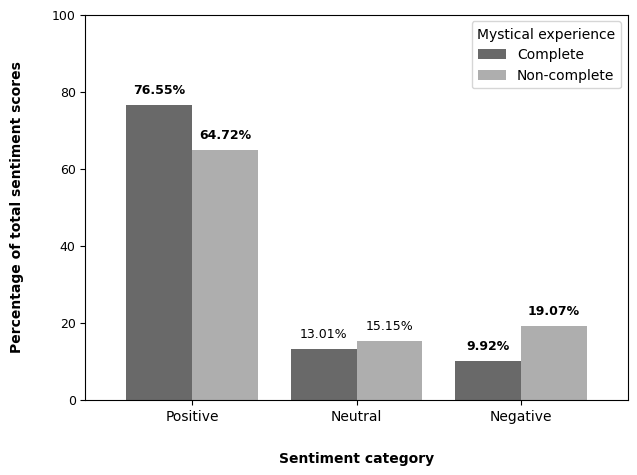

In [39]:
fisher_results_df["p-value"] = pd.to_numeric(fisher_results_df["p-value"])
significant_categories = fisher_results_df[fisher_results_df["p-value"] < 0.05]["Category"].tolist()

percentages_complete = [score / total_score_complete * 100 for score in scores_complete]
percentages_non_complete = [score / total_score_non_complete * 100 for score in scores_non_complete]

df_percentages = pd.DataFrame({
    "Complete": percentages_complete,
    "Non-complete": percentages_non_complete,
})

fig, ax = plt.subplots(figsize=(7, 5))
bars = df_percentages.plot(kind="bar", ax=ax, width=0.8, color=["#696969", "#AEAEAE"])

for container in bars.containers:
    for bar in container:
        category = categories[container.index(bar)]
        label = f"{bar.get_height():.2f}%"
        label_style = {"fontweight": "bold"} if category in significant_categories else {"fontweight": "normal"}
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 3,
            label,
            ha="center",
            fontweight=label_style["fontweight"],
            fontsize=9
        )

plt.xlabel("Sentiment category", fontweight="bold", fontsize=10, labelpad=20)
plt.ylabel("Percentage of total sentiment scores", fontweight="bold", fontsize=10, labelpad=20)
plt.legend(title="Mystical experience")
plt.yticks(fontsize=9)
plt.ylim(0, 100)
plt.xticks(fontsize=10)
ax.set_xticklabels(categories, rotation=0)

figure5_html = """
<p style="font-size: 14px">
    <strong>Figure 5.</strong> Bar plot comparing the proportions of positive, negative, and neutral sentiments 
    between participants who experienced a complete mystical experience (<i>N</i> = 152) and those who did not (<i>N</i> = 186).
    Statistically significant differences (<i>p</i> < 0.05) are highlited in bold.
</p>
"""
display(HTML(figure5_html))

plt.show()

We can see that descriptions of complete mystical experiences were characterized by a higher frequency of positive emotions and a lower frequency of negative emotions compared to the non-complete group. Both groups showed statistically equivalent levels of neutral affect.

## **5.4. Participants' subjective assessment of the influence**

In [40]:
influence_columns = [col for col in df.columns if col.startswith("influence")]

replacement_mapping = {
    1: "Definitely positive",
    2: "Rather positive",
    3: "No influence",
    4: "Rather negative",
    5: "Definitely negative"   
}

df[influence_columns] = df[influence_columns].replace(replacement_mapping)

### **5.4.1. Fear of death**

In [41]:
filtered_df_complete = df[df["MEQ_complete"] == 1]
filtered_df_non_complete = df[df["MEQ_complete"] == 0]

index = ["Definitely negative", "Rather negative", "No influence", "Rather positive", "Definitely positive"]

complete_counts = (filtered_df_complete["influence_fear"].value_counts()).reindex(index, fill_value=0)
non_complete_counts = (filtered_df_non_complete["influence_fear"].value_counts().reindex(index, fill_value=0))

total_complete = complete_counts.sum()
total_non_complete = non_complete_counts.sum()

complete_percentages = ((complete_counts / total_complete) * 100).reindex(index, fill_value=0)
non_complete_percentages = ((non_complete_counts / total_non_complete) * 100).reindex(index, fill_value=0)

In [42]:
fisher_results = []

for category in index:
    observed = [
        [
            complete_counts[category], 
            non_complete_counts[category]
        ],
        [
            total_complete - complete_counts[category],
            total_non_complete - non_complete_counts[category]
        ]
    ]
    
    oddsratio, p_value = fisher_exact(observed)
    
    fisher_results.append({
        "Category": category,
        "Odds ratio": f"{oddsratio:.2f}",
        "p-value": f"{p_value:.3f}"
    })

fisher_results_df = pd.DataFrame(fisher_results)

fisher_results_df

,Category,Odds ratio,p-value
0,Definitely negative,0.00,0.017
1,Rather negative,0.10,0.008
2,No influence,0.32,0.000
3,Rather positive,1.35,0.123
4,Definitely positive,3.37,0.000


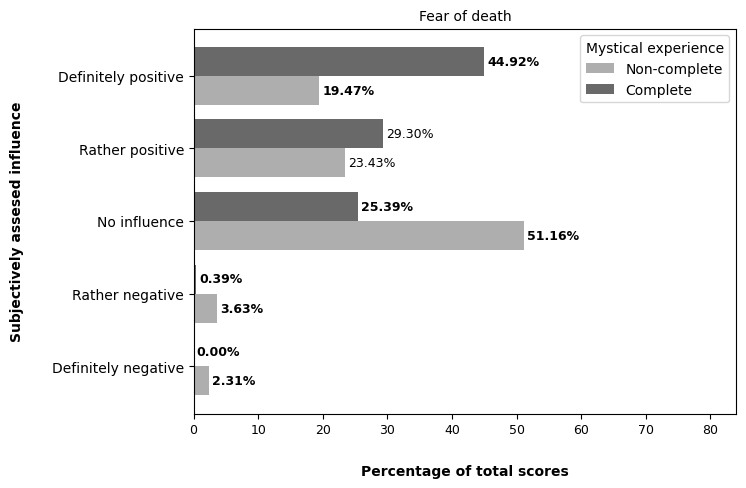

In [43]:
fisher_results_df["p-value"] = pd.to_numeric(fisher_results_df["p-value"])
significant_categories = fisher_results_df[fisher_results_df["p-value"] < 0.05]["Category"].tolist()

df_percentages = pd.DataFrame({
    "Non-complete": non_complete_percentages,
    "Complete": complete_percentages
})

fig, ax = plt.subplots(figsize=(7, 5))
bars = df_percentages.plot(kind="barh", ax=ax, width=0.8, color=["#AEAEAE", "#696969"])

for container in bars.containers:
    for bar in container:
        category = df_percentages.index[container.index(bar)]
        label = f"{bar.get_width():.2f}%"
        label_style = {"fontweight": "bold"} if category in significant_categories else {"fontweight": "normal"}
        ax.text(
            bar.get_width() + 0.5,
            bar.get_y() + bar.get_height() / 2,
            label,
            fontweight=label_style["fontweight"],
            fontsize=9,
            va="center"
        )

plt.title("Fear of death", fontsize=10)
plt.xlabel("Percentage of total scores", fontweight="bold", fontsize=10, labelpad=20)
plt.ylabel("Subjectively assesed influence", fontweight="bold", fontsize=10, labelpad=20)
plt.legend(title="Mystical experience")
plt.yticks(fontsize=10)
plt.xticks(fontsize=9)
plt.xlim(0, 84)

plt.show()

### **5.4.2. Empathy**

In [44]:
complete_counts = (filtered_df_complete["influence_empathy"].value_counts()).reindex(index, fill_value=0)
non_complete_counts = (filtered_df_non_complete["influence_empathy"].value_counts().reindex(index, fill_value=0))

total_complete = complete_counts.sum()
total_non_complete = non_complete_counts.sum()

complete_percentages = ((complete_counts / total_complete) * 100).reindex(index, fill_value=0)
non_complete_percentages = ((non_complete_counts / total_non_complete) * 100).reindex(index, fill_value=0)

In [45]:
fisher_results = []

for category in index:
    observed = [
        [
            complete_counts[category], 
            non_complete_counts[category]
        ],
        [
            total_complete - complete_counts[category],
            total_non_complete - non_complete_counts[category]
        ]
    ]
    
    oddsratio, p_value = fisher_exact(observed)
    
    fisher_results.append({
        "Category": category,
        "Odds ratio": f"{oddsratio:.2f}",
        "p-value": f"{p_value:.3f}"
    })

fisher_results_df = pd.DataFrame(fisher_results)

fisher_results_df

,Category,Odds ratio,p-value
0,Definitely negative,0.00,1.000
1,Rather negative,1.18,1.000
2,No influence,0.24,0.000
3,Rather positive,1.60,0.008
4,Definitely positive,2.44,0.000


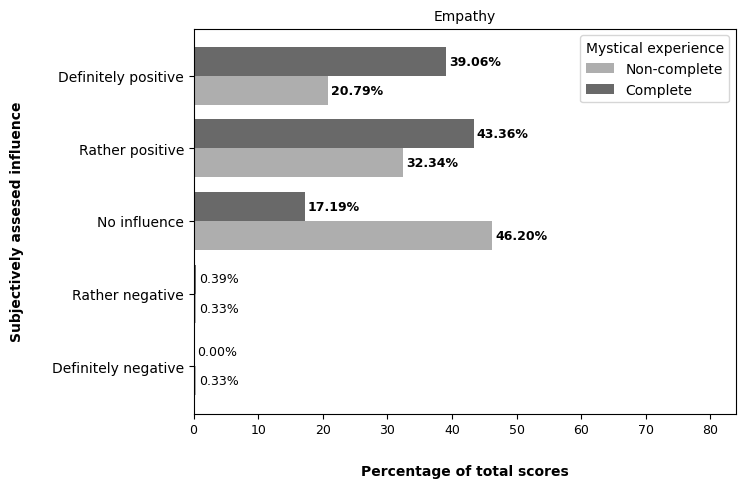

In [46]:
fisher_results_df["p-value"] = pd.to_numeric(fisher_results_df["p-value"])
significant_categories = fisher_results_df[fisher_results_df["p-value"] < 0.05]["Category"].tolist()

df_percentages = pd.DataFrame({
    "Non-complete": non_complete_percentages,
    "Complete": complete_percentages
})

fig, ax = plt.subplots(figsize=(7, 5))
bars = df_percentages.plot(kind="barh", ax=ax, width=0.8, color=["#AEAEAE", "#696969"])

for container in bars.containers:
    for bar in container:
        category = df_percentages.index[container.index(bar)]
        label = f"{bar.get_width():.2f}%"
        label_style = {"fontweight": "bold"} if category in significant_categories else {"fontweight": "normal"}
        ax.text(
            bar.get_width() + 0.5,
            bar.get_y() + bar.get_height() / 2,
            label,
            fontweight=label_style["fontweight"],
            fontsize=9,
            va="center"
        )
    
plt.title("Empathy", fontsize=10)
plt.xlabel("Percentage of total scores", fontweight="bold", fontsize=10, labelpad=20)
plt.ylabel("Subjectively assesed influence", fontweight="bold", fontsize=10, labelpad=20)
plt.legend(title="Mystical experience")
plt.yticks(fontsize=10)
plt.xticks(fontsize=9)
plt.xlim(0, 84)

plt.show()

### **5.4.2. Life satisfaction**

In [47]:
complete_counts = (filtered_df_complete["influence_satisfaction"].value_counts()).reindex(index, fill_value=0)
non_complete_counts = (filtered_df_non_complete["influence_satisfaction"].value_counts().reindex(index, fill_value=0))

total_complete = complete_counts.sum()
total_non_complete = non_complete_counts.sum()

complete_percentages = ((complete_counts / total_complete) * 100).reindex(index, fill_value=0)
non_complete_percentages = ((non_complete_counts / total_non_complete) * 100).reindex(index, fill_value=0)

In [48]:
fisher_results = []

for category in index:
    observed = [
        [
            complete_counts[category], 
            non_complete_counts[category]
        ],
        [
            total_complete - complete_counts[category],
            total_non_complete - non_complete_counts[category]
        ]
    ]
    
    oddsratio, p_value = fisher_exact(observed)
    
    fisher_results.append({
        "Category": category,
        "Odds ratio": f"{oddsratio:.2f}",
        "p-value": f"{p_value:.3f}"
    })

fisher_results_df = pd.DataFrame(fisher_results)

fisher_results_df

,Category,Odds ratio,p-value
0,Definitely negative,0.00,0.503
1,Rather negative,0.35,0.157
2,No influence,0.22,0.000
3,Rather positive,1.15,0.438
4,Definitely positive,2.54,0.000


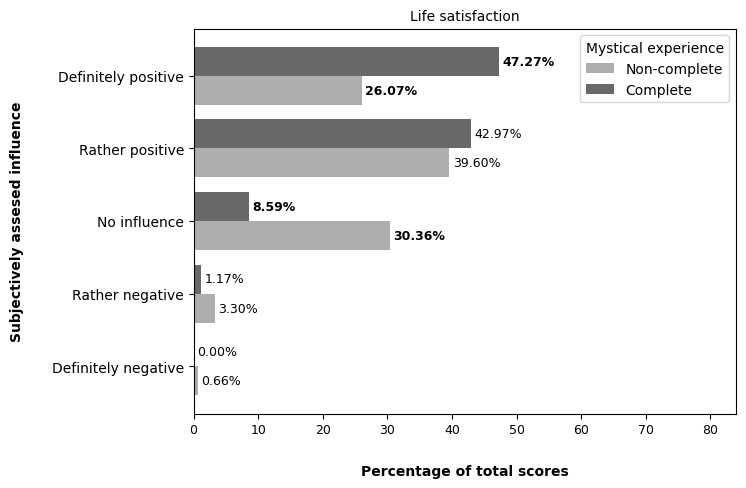

In [49]:
fisher_results_df["p-value"] = pd.to_numeric(fisher_results_df["p-value"])
significant_categories = fisher_results_df[fisher_results_df["p-value"] < 0.05]["Category"].tolist()

df_percentages = pd.DataFrame({
    "Non-complete": non_complete_percentages,
    "Complete": complete_percentages
})

fig, ax = plt.subplots(figsize=(7, 5))
bars = df_percentages.plot(kind="barh", ax=ax, width=0.8, color=["#AEAEAE", "#696969"])

for container in bars.containers:
    for bar in container:
        category = df_percentages.index[container.index(bar)]
        label = f"{bar.get_width():.2f}%"
        label_style = {"fontweight": "bold"} if category in significant_categories else {"fontweight": "normal"}
        ax.text(
            bar.get_width() + 0.5,
            bar.get_y() + bar.get_height() / 2,
            label,
            fontweight=label_style["fontweight"],
            fontsize=9,
            va="center"
        )
    
plt.title("Life satisfaction", fontsize=10)
plt.xlabel("Percentage of total scores", fontweight="bold", fontsize=10, labelpad=20)
plt.ylabel("Subjectively assesed influence", fontweight="bold", fontsize=10, labelpad=20)
plt.legend(title="Mystical experience")
plt.yticks(fontsize=10)
plt.xticks(fontsize=9)
plt.xlim(0, 84)

plt.show()

# **6. Conclusions**